# AMATH 563 HW3
In this problem you will use a specific construction of the graph Laplacian operator to approximate the
Laplacian differential operator on arbitrary domains.

-  In parts 1–4 you work on the unit box and verify that
the eigenvectors of the graph Laplacian converge to those of the differential operator.
-  In part 5, you modify
the domain to an L-shaped domain. In correspondence with the literature on graph Laplacians here we
assume the eigenvalues of matrices are ordered in increasing order.

*Some of the calculations here can be
expensive and the matrices can become quite large. Make sure you take advantage of sparse matrices and
benchmark your code with small data sets.*

In [2]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform

## Problem 1
Let $\Omega = [0,1]^2 \subset \mathbb R^2$ and let $x_1, \dots, x_m$ be uniformly distributed random points in $\Omega$. We define $X = \{x_1, \dots, x_m\}$ to be our set of scattered data points and define the weighted graph $G = {X, W}$ with the weight matrix $W \in \mathbb R^{m \times m}$ as 

$$w_{ij} = \kappa_\varepsilon(||\mathbf x_i - \mathbf x_j||_2), \qquad \text{where} \quad \kappa_\varepsilon(t) := \begin{cases} (\pi \varepsilon^2)^{-1} & t \le \varepsilon, \\ 0 & t> \varepsilon.\end{cases}$$

The parameter $\varepsilon > 0$ controls the bandwidth of the kernel $\kappa$ and in turn the local connectivity of the graph $G$. Throughout this assignment we choose 

$$\varepsilon = C \frac{\log(m)^{3/4}}{m^{1/2}},$$

where $C>0$ is a constant (you should find that $C=1$ is sufficient but feel free to tune this number). Let $L=D-W$ be the unnormalized graph Laplacian matrix of $G$ and fix $m=2048$. Then compute the first four eigenvectors of $L$, i.e., those corresponding to the four smallest eigenvalues of $L$. Present a plot of these four eigenvectors as functions over $\Omega$; you may use 3D scatter plots or contour plots.

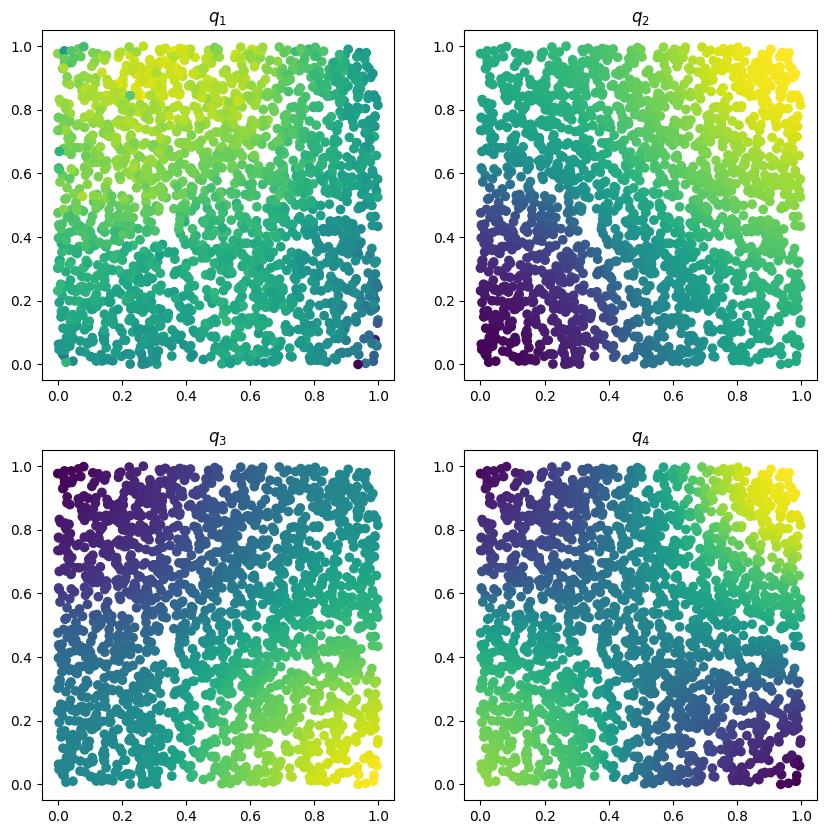

In [77]:
np.random.seed(1)

# Defining constants
m = 2048
C = 1

# Generating uniformly distributed random points in the unit square
X = np.random.rand(m, 2)

# Computing epsilon
epsilon = C * (np.log(m) ** (3/4)) / (m ** (1/2))

# Calculating pairwise distances
distances = squareform(pdist(X))

# Applying the kernel function
W = np.where(distances <= epsilon, 1 / (np.pi * epsilon ** 2), 0)

# Calculating the degree matrix D
D = np.diag(W.sum(axis=0))

# Calculating the Laplacian L
L = D - W

# Compute the first four eigenvectors
eigenvalues, eigenvectors = spsl.eigsh(L, k=4, which='SM')

# Plot eigenvectors
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.scatter(X[:, 0], X[:, 1], c=eigenvectors[:, i], cmap='viridis')
    ax.set_title(f"$q_{i+1}$")
plt.show()


## Problem 2
Now consider the differential operator 

$$\mathcal L f \mapsto - \left( \frac{\partial^2 f}{\partial x_1^2} +\frac{\partial^2 f}{\partial x_2^2} \right),$$

that is well-defined for functions $f: \Omega \mapsto \mathbb R$ that are twice continuously differentiable, i.e., $f \in C^2(\Omega)$. Observe that for integers $n, k \ge 0$, the functions 

$$\psi(\mathbf x) = \cos(n \pi x_1) \cos(k\pi x_2),$$

solve the Neumann eigenvalue problem for the operator $\mathcal L$, i.e., 

$$\begin{align*} \mathcal L \psi = \lambda(n, k) \psi, &&&& \text{in $\Omega$,} \\ \nabla \psi \cdot \mathbf n = 0, &&&& \text{on boundary of $\Omega$.} \end{align*}$$

where $\mathbf n$ denotes the outward unit normal vector on the boundary of $\Omega$. 

Now let $\mathbf q_1, \dots, \mathbf q_4 \in \mathbb R^m$ be the eigenvectors of the graph Laplacian $L$ as computed in part 1, and define the vectors $\boldsymbol \psi_1, \dots, \boldsymbol \psi_4 \in \mathbb R^m$ as follows:

$$\boldsymbol \psi_j = \frac{\tilde{\boldsymbol \psi}_j}{||\tilde{\boldsymbol \psi}_j||_2},$$

where the entries of $\tilde{\boldsymbol \psi}_j$ contain the point values of the first four eigennfunctions $\psi(x)$, at the vertices $X$. Once again fix $m=2048$ and present a plot of the vectors $\boldsymbol \psi_1, \dots, \boldsymbol \psi_4$ akin to part 1. Inspect the plots visually and comment on similarities and differences between $\mathbf q_j$ and the $\boldsymbol \psi_j$.

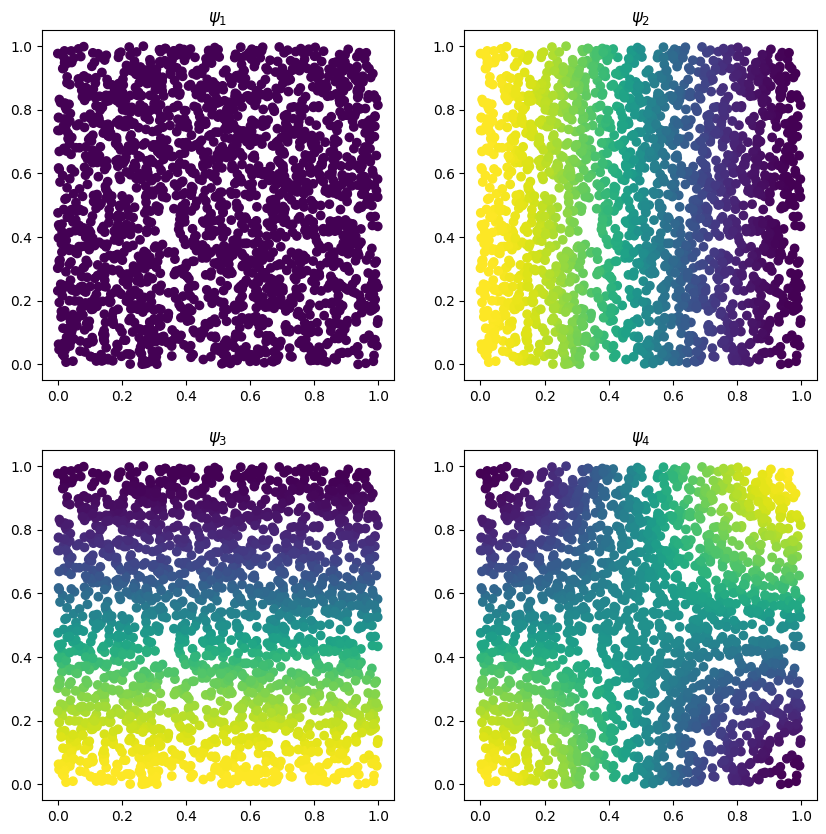

In [78]:
# Defining psi function
def psi(n, k, X):
    return np.cos(n * np.pi * X[:, 0]) * np.cos(k * np.pi * X[:, 1])

psi_values = np.zeros((m, 4))
for i, (n, k) in enumerate([(0,0), (1,0), (0,1), (1,1)]):
    psi_values[:, i] = psi(n, k, X)

# Normalizing
psi_norm = np.linalg.norm(psi_values, axis=0)
psi_values /= psi_norm

# Plot eigenvectors
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.scatter(X[:, 0], X[:, 1], c=psi_values[:, i], cmap='viridis')
    ax.set_title(f"$\psi_{i+1}$")
plt.show()

## Problem 3
We now wish to show that $\operatorname{span}\{\mathbf q_1, \dots, \mathbf q_4\} \approx \operatorname{span}\{\boldsymbol \psi_1, \dots, \boldsymbol \psi_4\}$. Choose $m=2^7, 2^5, \dots, 2^10$. For each value of $m$ proceed as in part $1$ to generate the random points $X$, compute the corresponding value of $\varepsilon (m)$, and compute the four eigenvectors $\mathbf q_1, \dots, \mathbf q_4$. Also compute the vectors $\boldsymbol \psi_1, \dots, \boldsymbol \psi_4$ as above. Then define the matrices 

$$Q := [\boldsymbol q_1|\dots|\boldsymbol q_4] \in \mathbb R^{m \times 4}, \qquad \boldsymbol \Psi := [\boldsymbol \psi_1, \dots, \boldsymbol \psi_4] \in \mathbb R^{m \times 4},$$

and the projectors 

$$P_Q := QQ^T, \qquad P_\Psi := \boldsymbol \Psi \boldsymbol \Psi^T.$$

Then compute the error 

$$\operatorname{error}(m):=||P_Q P_\Psi - P_\Psi P_Q||_F.$$

For each value of $M$, copmute this error over at least 30 trials where the points in $X$ are redrawn at random. Present a loglog plot of the average error as a function of $m$.

In [68]:
# Define a function that performs a single trial for a given m
def trial(m):
    # Constants
    C = 1

    # Generate uniformly distributed random points in the unit square
    X = np.random.rand(m, 2)

    # Compute epsilon
    epsilon = C * (np.log(m) ** (3/4)) / (m ** (1/2))

    # Calculate pairwise distances and apply the kernel function
    distances = squareform(pdist(X))
    W = np.where(distances <= epsilon, 1 / (np.pi * epsilon ** 2), 0)

    # Calculate the degree matrix D and the Laplacian L
    D = np.diag(W.sum(axis=0))
    L = D - W

    # Compute the first four eigenvectors
    _, q = spsl.eigsh(L, k=4, which='SM')

    # Compute the first four normalized eigenfunctions
    psi_values = np.zeros((m, 4))
    for i, (n, k) in enumerate([(0,0), (1,0), (0,1), (1,1)]):
        psi_values[:, i] = psi(n, k, X)
    psi_values /= np.linalg.norm(psi_values, axis=0)

    # Compute the projectors P_Q and P_Psi
    P_Q = q @ q.T
    P_Psi = psi_values @ psi_values.T

    # Compute and return the error
    return np.linalg.norm(P_Q @ P_Psi - P_Psi @ P_Q)

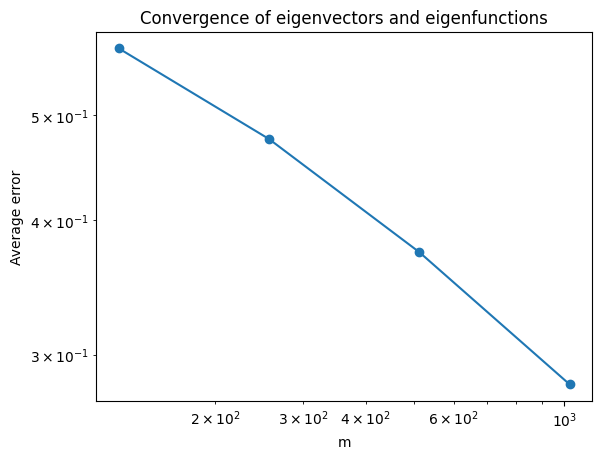

In [69]:
# Run multiple trials to compute average error
ms = 2 ** np.arange(7, 11)
num_trials = 30
errors = np.zeros((len(ms), num_trials))

for i, m in enumerate(ms):
    for j in range(num_trials):
        errors[i, j] = trial(m)

average_errors = errors.mean(axis=1)

# Plot the errors 
plt.loglog(ms, average_errors, marker='o')
plt.xlabel('m')
plt.ylabel('Average error')
plt.title('Convergence of eigenvectors and eigenfunctions')
#plt.grid(True)
plt.show()

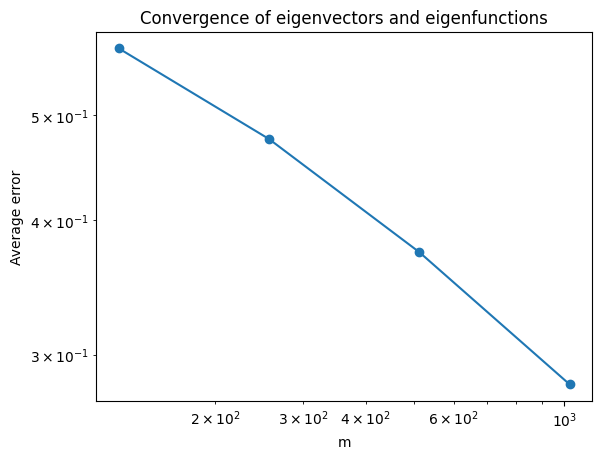

In [64]:
# Plot the errors 
plt.loglog(ms, average_errors, marker='o')
plt.xlabel('m')
plt.ylabel('Average error')
plt.title('Convergence of eigenvectors and eigenfunctions')
#plt.gca().set_xticks(ms, [f'$2^{{{int(m)}}}$' for m in range(7,11)])

plt.show()

## Problem 4
Hopefully the above results have convinced you that the spectrum of $L$ converges to that of $\mathcal L$ as $m \rightarrow \infty$, albeit slowly. We now use this observation to approximate the spectrum of $\mathcal L$ on non-standard domains $\Omega$. Let $\Omega$ be the $L$-shaped domain 

$$\Omega = \left( [0,1]^2 \right) \cup ([1,2]\times[0,1])\cup([0,1]\times[1,2]),$$

i.e., the $[0,2]^2$ box with the top right quadrant removed. Take $m=2^{13}$, generate uniformly random points $X$ on $\Omega$ and proceed as in part 1 to plot the $\mathbf q_7, \dots, \mathbf q_10$ eigenvectors of $L$. 

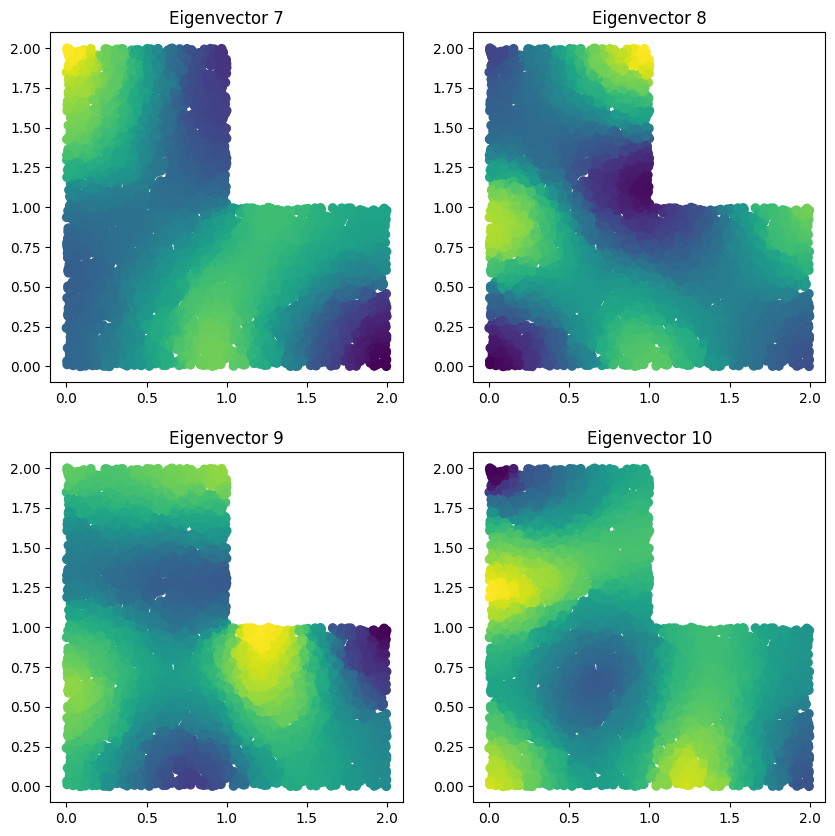

In [22]:
# Constants
m = 2**13
C = 1

# Generate random points in the unit square
X = 2 * np.random.rand(m, 2)

# Keep only the points that are in the L-shaped region
mask = np.logical_not((X[:, 0] > 1) & (X[:, 1] > 1))
X = X[mask]

# Compute epsilon
epsilon = C * (np.log(m) ** (3/4)) / (m ** (1/2))

# Calculate pairwise distances and apply the kernel function
distances = squareform(pdist(X))
W = np.where(distances <= epsilon, 1 / (np.pi * epsilon ** 2), 0)

# Calculate the degree matrix D and the Laplacian L
D = np.diag(W.sum(axis=0))
L = D - W

# Compute the first ten eigenvectors
_, q = spsl.eigsh(L, k=10, which='SM')

# Plot eigenvectors
fig = plt.figure(figsize=(10, 10))
for i in range(7, 11):
    ax = fig.add_subplot(2, 2, i-6)
    ax.scatter(X[:, 0], X[:, 1], c=q[:, i-1], cmap='viridis')
    ax.set_title(f"Eigenvector {i}")
plt.show()
